
# <font color='green'>sentiment Analysis</font> ![title](./resources/img/sent_twitter.png)

## <font color='red'>Reading Data</font>
***

#### Import liberies

Refer to the web pages for individual libraries
* [Pandas](http://pandas.pydata.org/), to load and manage data
* [Matplotlib](http://matplotlib.org/), for visualization
* [numpy](http://www.numpy.org/) for painting representation and manipulation
* [re](https://docs.python.org/3/library/re.html) for regular expression
* [nltk](http://www.nltk.org/) for pretreatment

In [1]:
import pandas as pd
import re
import os
from copy import copy
import collections
import scipy
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

#### Reading the dataset
Some of the data "downloaded_cleansed_B" is produced out of the "downloaded_cleansed_A". The difference is:
- "downloaded_cleansed_A" has three columns that we won't use.
- "downloaded_cleansed_A" has repeatted tweets.

In [105]:
df = pd.read_csv('./data/train/downloaded_cleansed_B.tsv', sep= '\t', header=None)
print (df.shape)
df.head()

(9665, 4)


,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,Not Available
2,262163168678248449,35266263,negative,Not Available
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,Not Available


Note that some tweets are "Not Available". We will reject them because it will not help in the analysis of feelings

#### Supprimer tous les tweets "NOT AVAILABLE"

In [106]:
df = df[df[3] != "Not Available"]
df.head()

,0,1,2,3
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


In [107]:
df.shape

(7205, 4)

#### <font color='blue'>Training tweets are too limited: just 7205 tweets ...</font>

#### Draw the data

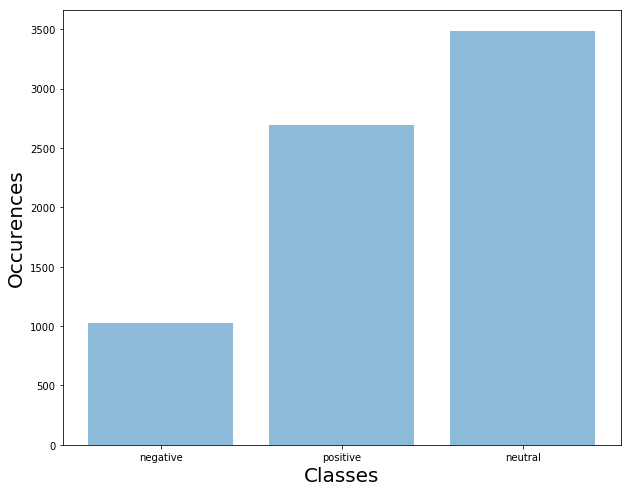

In [5]:
# calculate the total number of occurrences of each class
y = [len(df[df[2] == i]) for i in ['negative', 'positive', 'neutral']]
# X axis
objects = ['negative', 'positive', 'neutral']
x_pos = range(len(objects))

# Draw Diagram
plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, objects)
plt.ylabel('Occurences').set_size(20)
plt.xlabel('Classes').set_size(20)

#### Interpretation
From the graph above, we can clearly note that the "negative" class has the fewest samples in the data compared to "positive" and "neutral". As a result, the data appears to be unbalanced and underfit the "negative" class.

In [109]:
raw_tweets = list(df[3])
labels = df[2]

### Sentiment140 Score

Before doing any preprocessing over the tweets, we will use the score of Sentiment140 corpus first. This corpus has the score of the most common words (formal, informal) used in twitter. The score is a number between [-4.999: 4.999].

The score will be divided into three parts:
- unigram score  --> 'unigram140_score'
- bigram score   --> 'bigram140_score'
- pair score     --> 'pair140_score'

In [7]:
def Sentiment140_dictionary(filename):
    sentiment140 = {}
    with open(filename) as fin:
        line = fin.readline()[:-1]
        while line:
            line = line.split('\t')
            sentiment140[line[0]] = float(line[1])
            line = fin.readline()[:-1]
    return sentiment140


def unigram140Polarity(tweet, d):
    score=0.0
    reps = 0
    for w in tweet.split(' '):
        if w in d.keys():
            reps += 1
            score+=d[w]
    return score, reps

unigram140_d = Sentiment140_dictionary('resources/Sentiment140/unigrams-pmilexicon.txt')
unigram140Score, unigram140Reps = [], []
for tweet in raw_tweets:
    score, reps = unigram140Polarity(tweet.lower(), unigram140_d)
    unigram140Score.append(score)
    unigram140Reps.append(reps)

len(unigram140Score)

7205

In [110]:
def find_bigrams(input_list):
    bigram_list = []
    for i in range(len(input_list)-1):
        bigram_list.append(input_list[i] + " " + input_list[i+1])
    return bigram_list


def bigram140Polarity(tweet, d):
    score=0.0
    reps = 0
    tweet = find_bigrams(tweet.split(' '))
    for w in tweet:
        if w in d.keys():
            reps += 1
            score+=d[w]
    return score, reps


bigram140_d = Sentiment140_dictionary('resources/Sentiment140/bigrams-pmilexicon.txt')
bigram140Score, bigram140Reps = [], []
for tweet in raw_tweets:
    score, reps = bigram140Polarity(tweet.lower(), bigram140_d)
    bigram140Score.append(score)
    bigram140Reps.append(reps)

len(bigram140Score)

7205

### SemEval2015 English lexicon 

These are the very first and last entries of 'SemEval2015-English-Twitter-Lexicon.txt':
- 0.984	loves
- 0.984	#inspirational
- 0.969	amazing
- 0.969	#peaceful
- 0.953	#greatness
- ...
- -0.969	abuse
- -0.969	#failure
- -0.982	kill
- -0.984	bitches
- -0.984	#disappointment

In [13]:
def loadSemEval(filename):
    f = open(filename,'r')
    lexicon = {}
    line = f.readline()
    while line:
        l = line[:-1].split('\t')
        lexicon[l[1]] = float(l[0])
        line = f.readline()
    return lexicon


def SemEvalLexiconPolarity(tweet, EnglishLexicon):
    score=0.0
    reps = 0
    for w in tweet.split(' '):
        if w in EnglishLexicon.keys():
            reps += 1
            score += EnglishLexicon[w]
    return score, reps

EnglishLexicon = loadSemEval('./resources/SemEval2015-English-Twitter-Lexicon.txt')
SemEvalScore, SemEvalReps = [], []
for tweet in raw_tweets:
    score, reps = SemEvalLexiconPolarity(tweet.lower(), EnglishLexicon)
    SemEvalScore.append(score)
    SemEvalReps.append(reps)

print ("Number of EnglishLexicon entries %d" % len(EnglishLexicon.keys()))
len(SemEvalScore)

Number of EnglishLexicon entries 1516


7205

***
## <font color='red'>Pre-train the tweets</font>
https://nlp.stanford.edu/IR-book/html/htmledition/determining-the-vocabulary-of-terms-1.html
***

#### Delete slangs from tweets
By slangs, we mean words like:
- i've --> I have
- 12be --> want to be
- *4u  --> kiss for you
- ...

And these parallel-terms are read from <font color='red'>'./resources/internetSlangs.txt'</font> file. Here is the first five lines in that file:
- *4u,%,kiss for you
- *67,%,unknown
- *eg*,%,evil grin
- 7734,%,hello
- 0day,%,software illegally obtained before it was released

In [14]:
def loadSlangs(filename):
    """
    This function reads the file that contains the slangs, and put them in a dictionary such that
    the key is the "slang" and the value is the acronym.
    slangs['i've'] = 'i have'
    slang['12be'] = 'want to be'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    slangs={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            slangs[l[0].lower()]=l[1][:-1].lower()  #HERE
        line=fi.readline()
    fi.close()
    return slangs


def replaceSlangs(tweet,slangs):
    """
    This function is used to replace the slang in the original tweets and replace them with the acronym.
    And it's also returns the the tweet in lower-case letters
    """
    result=''
    tweet = tweet.lower()
    words=tweet.split()
    for w in words:
        if w in slangs.keys():
            result=result+slangs[w]+" "
        else:
            result=result+w+" "
    return result.strip()

slangs = loadSlangs('./resources/internetSlangs.txt')
raw_tweets = [replaceSlangs(tweet, slangs) for tweet in raw_tweets]

#### Replacing apostrophe words

By that, we mean to change words like 'can't', 'cant' into 'can not'. These words are in a txt file called 'apostrophe_words.txt' existed in 'resources' directory. 
We need to do that to handle the negation problem.

In [15]:
def load_apostrophe_words(filename):
    """
    This function reads the file that contains all words that have apostrophe, and put them in a dictionary 
    such that the key is the "word containing apostrophe" and the value is the "the word without apostrophe".
    slangs['i've'] = 'i have'
    slang['I'm] = 'I am'
    ...
    CAUTION: the keys and values are lower-case letters
    """
    apo={}
    fi=open(filename,'r')
    line=fi.readline()
    while line:
        l=line.split(r',%,')
        if len(l) == 2:
            apo[l[0].lower()]=l[1][:-1].lower()
        line=fi.readline()
    fi.close()
    return apo


def replace_apostrophe(tweet,apos):
    result=''
    words=tweet.split()
    for w in words:
        if w in apos.keys():
            result=result+apos[w]+" "
        else:
            result=result+w+" "
    return result.strip()

apos = load_apostrophe_words('./resources/apostrophe_words.txt')
raw_tweets = [replace_apostrophe(tweet, apos) for tweet in raw_tweets]

Apply standard preprocessing techniques

* https://nlp.stanford.edu/IR-book/html/htmledition/tokenization-1.html
* https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html


#### Use NRC emoticon lexicon

We will replace the emoticon with its associated meaning.

In [16]:
TT = TweetTokenizer()

def emoticondictionary(filename):
    """
    Reads the emoticon file and represents it as dictionary where the emoticon is the key, 
    and its indication as a value
    """
    emo_scores = {'Positive': 'positive', 'Extremely-Positive': 'positive', 
                  'Negative': 'negative','Extremely-Negative': 'negative',
                  'Neutral': 'neutral'}
    emo_score_list = {}
    fi = open(filename,"r")
    l = fi.readline()
    while l:
        #replace the "Non-break space" with the ordinary space " "
        l = l.replace("\xa0"," ") #HERE
        li = l.split(" ")
        l2 = li[:-1] #removes the polarity of the emoticon ('negative', 'positive')
        l2.append(li[len(li) - 1].split("\t")[0]) #gets the last emoticon attached to the polarity by '\t'
        sentiment=li[len(li) - 1].split("\t")[1][:-1] #gets only the polarity, and removes '\n'
        score=emo_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            emo_score_list[l2[i]]=l2[len(l2)-1]
        l=fi.readline()
    return emo_score_list

dict = emoticondictionary('./resources/emoticon.txt')


# substititue emoticon with its associated sentiment
def subsEmoticon(tweet,d):
    l = TT.tokenize(tweet)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet


raw_tweets = [subsEmoticon(tweet, dict) for tweet in raw_tweets]
# print(":D X3 :|")
# subsEmoticon(":D X3 :|", dict)

#### Handle Negation

Following the work of Pang et al.(2002), we define a negated context as a segment of a tweet that starts with a negation word (e.g., no, never) and ends with one of the punctuation marks: ‘,’, ‘.’, ‘:’, ‘;’, ‘!’, ‘?’.

After handling the negtation, a tweet like the that 'I don't like vegan food' would be 'I do not like_not vegan_not food_not.'.

In [17]:
negation_words = set(['barely', 'hardly', 'lack', 'never', 'neither', 'no', 'nobody', \
                      'not', 'nothing', 'none', 'nowhere', 'shortage', 'scarcely'])
punctuations = [',', '.', ':', ';', '!', '?']

def handle_negation(tweet):
    output = []
    negate = False
    for word in tweet:
        if word in punctuations and negate:
            negate = False
        if negate and not word in negation_words:
            output.append(word+"_not")
        else:
            output.append(word)
        if word in negation_words and not negate:
            negate = True
        elif word in negation_words and negate:
            negate = False
    return output

raw_tweets = [handle_negation(tweet) for tweet in raw_tweets]

#### Now, we will lemmatize our words
lemmatizing is like converting the word 'networks' into 'network'.

In [18]:
mmer = WordNetLemmatizer()
# Lemmatize the tweets
def lemma(tweet):
    return ' '.join([mmer.lemmatize(word) for word in tweet])

Preprocessing tweets handles different issues:
- removes punctuation characters like , . : ; etc.
- removes numbers from the tweet.
- removes any additional spaces in the tweet.
- removes the occurrence of two or more characters in a word, eg. loooong -> loong

In [19]:
def preprocess(tweet):
    # delete symbols and URIs and tags (keep # and _)
    tweet =  ' '.join(re.sub("(@[A-Za-z0-9_]+)|([^0-9A-Za-z_# \t])|(\w+:\/\/\S+)", '', tweet).split()) #here _#
    # Convert '@username' to 'at_user'
    # tweet = re.sub('@[^\s]+','at_user',tweet)
    # remove hashtags
    # tweet = re.sub(r'#\s', '', tweet)
    # remove numbers
    tweet = re.sub('[0-9]', '', tweet)
    # remove additional spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    # replace the occurrence of 2 or more characters in a word, eg. loooong -> loong
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)
    return tweet

lemmatized_tweets = [lemma(tweet) for tweet in raw_tweets]
preprocessed_tweets = [preprocess(tweet) for tweet in lemmatized_tweets]
del lemmatized_tweets

#### Delete stopwords
https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html

In [20]:
stop_words = stopwords.words('english')
stop_words.extend([word+'_not' for word in stop_words]) #negation
stop_words = set(stop_words)
stop_words.update('j', 'im')
print (len(stop_words))

# remove stopwords
def rem_stop(tweet):
    words = tweet.split()
    tweet = ' '.join([word for word in words if word not in stop_words])
    return tweet

final_tweets = [rem_stop(tweet) for tweet in preprocessed_tweets]
del raw_tweets, preprocessed_tweets

print("\nCompare tweets before / after")
df['final_tweets'] = final_tweets
df[[3, 'final_tweets']].head(10)

359

Compare tweets before / after


,3,final_tweets
0,Gas by my house hit $3.39!!!! I'm going to Cha...,gas house hit going chapel hill sat positive
3,Iranian general says Israel's Iron Dome can't ...,iranian general say israels iron dome deal_not...
6,with J Davlar 11th. Main rivals are team Polan...,davlar th main rival team poland hopefully mak...
7,"Talking about ACT's &amp;&amp; SAT's, deciding...",talking acts sats deciding want go college app...
9,"They may have a SuperBowl in Dallas, but Dalla...",may superbowl dallas dallas winning_not superb...
10,Im bringing the monster load of candy tomorrow...,instant message bringing monster load candy to...
11,"Apple software, retail chiefs out in overhaul:...",apple software retail chief overhaul san franc...
12,@oluoch @victor_otti @kunjand I just watched i...,watched sridevis comeback remember sun morning...
14,#Livewire Nadal confirmed for Mexican Open in ...,#livewire nadal confirmed mexican open februar...
15,@MsSheLahY I didnt want to just pop up... but ...,didnt want pop yep chapel hill next wednesday ...


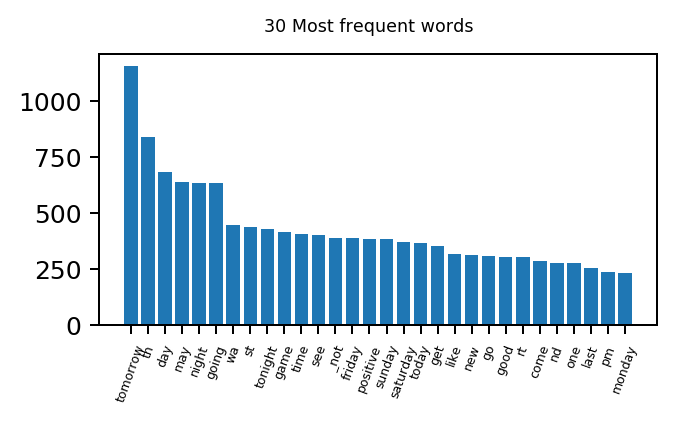

In [21]:
word_list = [word for line in final_tweets for word in line.split()]
counter = collections.Counter(word_list)

tmp_labels = [item[0] for item in counter.most_common(30)]
number = [item[1] for item in counter.most_common(30)]
nbars = len(counter.most_common(30))

plt.figure(figsize=(4,2), dpi=180)
plt.xticks(rotation=70, fontsize=5)
plt.bar(np.arange(nbars), number, tick_label=tmp_labels)
plt.suptitle("30 Most frequent words",fontsize=7)
plt.show()

In [22]:
counter["tomorrow"]

1155

***
## <font color='red'>Lexicon Classification</font>
***

#### Using MPQA Lexicon

These are the very first and last entries of the file 'mpqa.txt'
- abandoned priorpolarity=negative
- abandonment priorpolarity=negative
- abandon priorpolarity=negative
- abase priorpolarity=negative
- abasement priorpolarity=negative
- ...
- zealot priorpolarity=negative
- zealous priorpolarity=negative
- zealously priorpolarity=negative
- zenith priorpolarity=positive
- zest priorpolarity=positive

In [24]:
def MPQAdictionary(filename):
    """
    reads mpqa file which contains the polarity of some of the english words. e.g. 'love': 'positive'
    """
    MPQA_scores = {'priorpolarity=positive\n': 'positive','priorpolarity=negative\n': 'negative',
                  'priorpolarity=neutral\n': 'neutral', 'priorpolarity=both\n': 'neutral'}
    MPQA_score_list = {}
    fi = open(filename,"r")
    line = fi.readline()
    while line: 
        li = line.split(" ")
        l2 = li[:-1] # the word as a list
        sentiment=li[1] #the word's polarity
        score=MPQA_scores[sentiment]
        l2.append(score)
        for i in range(0,len(l2)-1):
            MPQA_score_list[l2[i]]=l2[-1]
            # negation
            if l2[-1] == 'positive':
                MPQA_score_list[l2[i]+'_not']='positive' 
            else:
                MPQA_score_list[l2[i]+'_not']='negative' 
        line=fi.readline()
    return MPQA_score_list


def subsMPQA(tweet,d):
    l = TT.tokenize(tweet)
    #print(l)
    tweet = [d[i] if i in d.keys() else i for i in l]
    return tweet

dictionary = MPQAdictionary('./resources/mpqa/mpqa.txt')
print ("Number of MPQA words: %d" % len(dictionary.keys()))
raw_tweets_MPQA = [subsMPQA(tweet,dictionary) for tweet in final_tweets]

print (subsMPQA(final_tweets[7], dictionary))
# watched sridevis comeback remember sun morning nta positive
subsMPQA("surprise happy abandoned", dictionary)

Number of MPQA words: 13772
['watched', 'sridevis', 'positive', 'remember', 'sun', 'morning', 'nta', 'positive']


['neutral', 'positive', 'negative']

#### Using Bing Liu Lexicon
These are the very first and last entries of the file 'positive-words.txt':
- a+
- abound
- abounds
- abundance
- abundant
- ...
- youthful
- zeal
- zenith
- zest
- zippy

These are the very first and last entries of the file 'negative-words.txt':
- 2-faced
- 2-faces
- abnormal
- abolish
- abominable
- ...
- zaps
- zealot
- zealous
- zealously
- zombie

In [25]:
lemmatized_tweets_MPQA = [lemma(tweet) for tweet in raw_tweets_MPQA]
ENGLISH_OPINION_LEXICON_LOCATION = os.path.join('resources/opinion-lexicon-English')
POS_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'positive-words.txt')
NEG_WORDS_FILE = os.path.join(ENGLISH_OPINION_LEXICON_LOCATION, 'negative-words.txt')

pos_words = []
neg_words = []

for pos_word in open(POS_WORDS_FILE, 'r').readlines()[35:]:
    pos_words.append(pos_word.rstrip())

for neg_word in open(NEG_WORDS_FILE, 'r').readlines()[35:]: #HERE
    neg_words.append(neg_word.rstrip())

#negation
expanded_pos = copy(pos_words)
expanded_pos.extend([word+"_not" for word in neg_words])
expanded_neg = copy(neg_words)
expanded_neg.extend([word+"_not" for word in pos_words])

#delete unnecessary objects
del pos_words, neg_words
del ENGLISH_OPINION_LEXICON_LOCATION, POS_WORDS_FILE, NEG_WORDS_FILE
print ("Number of positive words %d" % len(expanded_pos))
print ("Number of negative words %d" % len(expanded_neg))

def subsBINGP(tweet, pos_words):
    l = TT.tokenize(tweet)
    tweet = ['positive' if i in pos_words else i for i in l]
    return tweet

def subsBINGN(tweet, neg_words):
    l = TT.tokenize(tweet)
    tweet = ['negative' if i in neg_words else i for i in l]
    return tweet

raw_tweets_bing = [subsBINGP(tweet, expanded_pos) for tweet in lemmatized_tweets_MPQA]
raw_tweets_bing = [subsBINGN(tweet, expanded_neg) for tweet in lemmatized_tweets_MPQA]
del raw_tweets_MPQA, lemmatized_tweets_MPQA

subsBINGP("enjoy firas extraordinarily", expanded_pos)

Number of positive words 6789
Number of negative words 6789


['positive', 'firas', 'positive']

#### [Afinn](https://pypi.python.org/pypi/afinn)

These are the very first and last entries of 'afinn.txt':
- abandon	-2
- abandoned	-2
- abandons	-2
- abducted	-2
- abduction	-2
- ...
- yucky	-2
- yummy	3
- zealot	-2
- zealots	-2
- zealous	2

In [26]:
def loadAfinn(filename):
    f=open(filename,'r')
    afinn={}
    line=f.readline()
    while line:
        if " " in line:   #exclude entries like 'cool stuff    3'
            pass
        else:
            l=line[:-1].split('\t') #line[:-1] removes the '\r\n' character
            afinn[l[0]]=float(l[1])    # normalization -------> 
            afinn[l[0]+"_not"] = -float(l[1])  # negation
        line=f.readline()

    return afinn

afinn = loadAfinn('./resources/afinn.txt')
# print (afinn)
print ("Number of Afinn entries %d" % len(afinn.keys()))

def afinnPolarity(tweet, afinn):
    score=0.0
    reps = 0
    for w in tweet:
        if w in afinn.keys():
            reps += 1
            score+=afinn[w]
    return score, reps

Number of Afinn entries 4922


#### SentiWordNet

Here is the very first five lines of the csv file 'sentiWordnetBig.csv':

|POS|ID|PosSCore|NegScore|SynsetTerms|
|-|-------|-----|-----|-------------------|
|a|1740|0.125|0|able#1|
|a|2098|0|0.75|unable#1|
|a|2312|0|0|dorsal#2 abaxial#1|
|a|2527|0|0|ventral#2 adaxial#1|
|a|2730|0|0|acroscopic#1|

In [27]:
def loadSentiWordnet(filename): 
    output={}
    print ("Opening the SentiWordnet file ...")
    fi=open(filename,"r")
    line=fi.readline() # ignore the header
    line=fi.readline()
    print ("Loading...")

    while line:
        l=line.split('\t')
        try:
            sentence=l[4]
            new = [word for word in sentence.split() if (word[-2] == "#" and word[-1].isdigit())]
            pos=abs(float(l[2]))
            neg=abs(float(l[3]))
            neu=float(pos-neg)
        except:
            line=fi.readline()
            continue

        for w in new:
            output[(w[:-2])]=neu
            output[(w[:-2])+'_not'] = -neu   #negation
        line=fi.readline()
        
    fi.close()
    return output


sentiWordnet = loadSentiWordnet('./resources/sentiWordnetBig.csv')
print ("Number of sentiWordnet entries %d" % len(sentiWordnet.keys()))



def WordnetPolarity(tweet, sentiWordnet):
    score=0.0
    reps = 0
    for w in tweet:
        if w in sentiWordnet.keys():
            reps += 1
            score+=sentiWordnet[w]
    return score, reps

Opening the SentiWordnet file ...
Loading...
Number of sentiWordnet entries 294612


### Polarity calculation

In [30]:
BingMpqaScore = []
AfinnScore, AfinnReps = [], []
WordnetScore, WordnetReps = [], []
length = len(raw_tweets_bing)

for tw in raw_tweets_bing:
    Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
            Bing_MPQA +=  1
        if (i == 'negative'):
            Bing_MPQA -= 1
    BingMpqaScore.append(Bing_MPQA)
    tmp = afinnPolarity(tw, afinn)
    AfinnScore.append(tmp[0])
    AfinnReps.append(tmp[1])
    tmp = WordnetPolarity(tw, sentiWordnet)
    WordnetScore.append(tmp[0])
    WordnetReps.append(tmp[1])

    
#reshape
BingMpqaScore = np.array(BingMpqaScore).reshape(length, 1)
AfinnScore = np.array(AfinnScore).reshape(length, 1)
AfinnReps = np.array(AfinnReps).reshape(length, 1)
WordnetScore = np.array(WordnetScore).reshape(length, 1)
WordnetReps = np.array(WordnetReps).reshape(length, 1)
SemEvalScore = np.array(SemEvalScore).reshape(length, 1)
SemEvalReps = np.array(SemEvalReps).reshape(length, 1)
unigram140Score = np.array(unigram140Score).reshape(length, 1)
unigram140Reps = np.array(unigram140Reps).reshape(length, 1)
bigram140Score = np.array(bigram140Score).reshape(length, 1)
bigram140Reps = np.array(bigram140Reps).reshape(length, 1)

#Normalization
BingMpqaScore = BingMpqaScore/np.linalg.norm(BingMpqaScore)
AfinnScore = AfinnScore/np.linalg.norm(AfinnScore)
AfinnReps = AfinnReps/np.linalg.norm(AfinnReps)
WordnetScore = WordnetScore/np.linalg.norm(WordnetScore)
WordnetReps = WordnetReps/np.linalg.norm(WordnetReps)
SemEvalScore = SemEvalScore/np.linalg.norm(SemEvalScore)
SemEvalReps = SemEvalReps/np.linalg.norm(SemEvalReps)
unigram140Score = unigram140Score/np.linalg.norm(unigram140Score)
unigram140Reps = unigram140Reps/np.linalg.norm(unigram140Reps)
bigram140Score = bigram140Score/np.linalg.norm(bigram140Score)
bigram140Reps = bigram140Reps/np.linalg.norm(bigram140Reps)



#final_score_tweets (my score list)
df['bing_mpqa_score'] = BingMpqaScore
df['afinn_score'] = AfinnScore
df['wordnet_score'] = WordnetScore
df['sem_eval_score'] = SemEvalScore
all_scores = np.hstack( (BingMpqaScore, AfinnScore, WordnetScore, SemEvalScore, unigram140Score, bigram140Score) )
sum_score = np.sum(all_scores, axis=1).reshape(length, 1)
print (all_scores.shape)
df['final_score'] = sum_score

df[['bing_mpqa_score','afinn_score', 'wordnet_score', 'sem_eval_score','final_score', 'final_tweets' ,2]].head(10)

(7205, 6)


,bing_mpqa_score,afinn_score,wordnet_score,sem_eval_score,final_score,final_tweets,2
0,0.007947,0.007047,-0.003831,0.008469,0.013338,gas house hit going chapel hill sat positive,positive
3,0.015895,0.014093,0.003831,-0.003356,0.018780,iranian general say israels iron dome deal_not...,negative
6,0.007947,0.007047,0.000000,-0.002014,0.032309,davlar th main rival team poland hopefully mak...,positive
7,0.000000,0.000000,-0.005747,0.004899,-0.043744,talking acts sats deciding want go college app...,negative
9,-0.007947,-0.007047,-0.009579,0.000000,-0.034501,may superbowl dallas dallas winning_not superb...,negative
10,0.000000,0.000000,-0.009579,0.016953,-0.006370,instant message bringing monster load candy to...,neutral
11,0.000000,0.000000,-0.005747,0.000000,-0.005753,apple software retail chief overhaul san franc...,neutral
12,0.015895,0.014093,0.005747,0.006484,0.053167,watched sridevis comeback remember sun morning...,positive
14,0.007947,0.007047,0.001916,0.009598,0.010985,#livewire nadal confirmed mexican open februar...,neutral
15,0.015895,0.014093,-0.001916,0.018295,0.084706,didnt want pop yep chapel hill next wednesday ...,positive


##### Comparing the scores with the real results, we can conclude that the use of lexicon does not give very good results ... We must add scores for bi-grams.
##### You must then combine the lexicon / machine learning!

In [31]:
del df, raw_tweets_bing

***
## <font color='red'>Train the model</font>
***
#### Create a feature vector
* See [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) for more details

In [32]:
#CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None, ngram_range=(1,3))
features = count_vectorizer.fit_transform(final_tweets)
features.shape

(7205, 139450)

In [33]:
#reducing the CountVector
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
count_features = svd.fit_transform(features)
count_features = scipy.sparse.csr_matrix(count_features)
print (type(count_features))
count_features.shape

<class 'scipy.sparse.csr.csr_matrix'>


(7205, 5)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', preprocessor=None, stop_words=None, tokenizer=None, ngram_range=(1,3))
tfidf_features = tfidf_vectorizer.fit_transform(final_tweets)
del final_tweets
features.shape

(7205, 139450)

In [35]:
print (all_scores.shape, sum_score.shape, AfinnReps.shape, WordnetReps.shape, SemEvalReps.shape)
final_total = scipy.sparse.csr_matrix(np.hstack( (all_scores, sum_score, AfinnReps, WordnetReps, SemEvalReps, unigram140Reps, bigram140Reps) ))
print (type(final_total))
print (final_total.shape)

(7205, 6) (7205, 1) (7205, 1) (7205, 1) (7205, 1)
<class 'scipy.sparse.csr.csr_matrix'>
(7205, 12)


In [36]:
features = scipy.sparse.hstack([count_features, tfidf_features, final_total])
print (features.shape)

(7205, 139467)


In [37]:
# delete unnecessary data objects
del all_scores, sum_score, BingMpqaScore, AfinnScore, WordnetScore, SemEvalScore, unigram140Score, bigram140Score
del AfinnReps, WordnetReps, SemEvalReps, unigram140Reps, bigram140Reps
del count_features, tfidf_features, final_total


#### Put labels to train

In [38]:
mapper = {'positive': 1, 'negative': -1, 'neutral': 0}

labels = labels.map(mapper)
labels.shape

(7205,)

#### Import SVM

http://scikit-learn.org/stable/modules/svm.html

For a mathematical overview,
https://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html

#### Get the optimal regulation parameter using handout method

In [39]:
# # Takes around 15-20 minutes without the feature selection part
# # Takes a couple of miniutes after the feature selection

# KERNEL = 'linear'
# C_start = 0.1
# C_end = 4.0
# C_inc = 0.20

# C_values, precision_scores = [], []

# C_val = C_start
# best_precision_score = 0
# while (C_val < C_end):
#     C_values.append(C_val)
#     svc_model_loop = SVC(C=C_val, kernel=KERNEL, random_state=42)
#     svc_model_loop.fit(features, labels.ravel())
#     svc_predict_loop_test = svc_model_loop.predict(features)
    
#     precision_score = metrics.precision_score(labels, svc_predict_loop_test, average='micro')
#     precision_scores.append(precision_score)
#     if (precision_score > best_precision_score):
#         best_precision_score = precision_score
#         best_lr_predict_test = svc_predict_loop_test
        
#     C_val = C_val + C_inc

# best_score_C_val = C_values[precision_scores.index(best_precision_score)]
# print("Max value of {0:.3f} occured at C={1:.3f}".format(best_precision_score, best_score_C_val))

# %matplotlib inline 
# plt.plot(C_values, precision_scores, "-")
# plt.xlabel("C value")
# plt.ylabel("precision score")

In [40]:
# best_score_C_val = 3.900
# KERNEL = 'linear'
# classifier = SVC(kernel=KERNEL, C=best_score_C_val)
# classifier.fit(features, labels)

/home/anwar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anwar/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.595744824011
20
{'C': 1.6887473909571904, 'gamma': 0.74544949995820042}


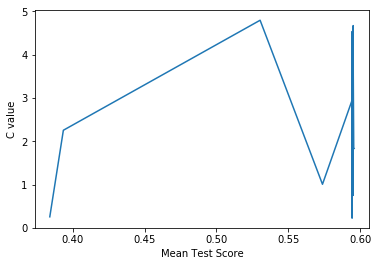

In [41]:
#Takes around 30 minutes
rand_list = {"C": scipy.stats.uniform(0, 5),
             "gamma": scipy.stats.uniform(0.1, 1)}

rand_search = RandomizedSearchCV(SVC(kernel='linear'), param_distributions = rand_list,\
                                 n_iter = 20, n_jobs = 4, scoring = 'f1_macro')
rand_search.fit(features, labels)

print(rand_search.best_score_)
print (len(rand_search.cv_results_['param_C'].data))
print (rand_search.best_params_)

rand_search.cv_results_['param_gamma'].data
plt.plot(sorted(rand_search.cv_results_['mean_test_score']), rand_search.cv_results_['param_C'].data, "-")
plt.xlabel("Mean Test Score")
plt.ylabel("C value")

In [42]:
KERNEL = 'linear'
classifier = SVC(kernel=KERNEL, C=rand_search.best_params_['C'], gamma=rand_search.best_params_['gamma'])
classifier.fit(features, labels)

SVC(C=1.6887473909571904, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.74544949995820042,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### Prediction on training data

In [43]:
from sklearn import metrics

nb_predict_train = classifier.predict(features)
#check accuracy
print("Accuracy: {:0.4f}".format(metrics.accuracy_score(labels, nb_predict_train)))
del features

Accuracy: 0.9943


In [44]:
#print confusion matrix
print("{}".format(metrics.confusion_matrix(labels, nb_predict_train, 
                                           labels=[1,-1, 0])))

print("{}".format(metrics.classification_report(labels, nb_predict_train, 
                                                labels=[1, -1, 0])))

[[2675    1   16]
 [   3 1004   17]
 [   4    0 3485]]
             precision    recall  f1-score   support

          1       1.00      0.99      1.00      2692
         -1       1.00      0.98      0.99      1024
          0       0.99      1.00      0.99      3489

avg / total       0.99      0.99      0.99      7205



### Predict using the model
***

#### Import test data

In [114]:
t_df = pd.read_csv('./data/test/actual/test_B_labeled.tsv', sep='\t', header=None)
t_df.shape

(8902, 4)

In [115]:
t_df = t_df[t_df[3] != 'Not Available']
t_df.shape

(7584, 4)

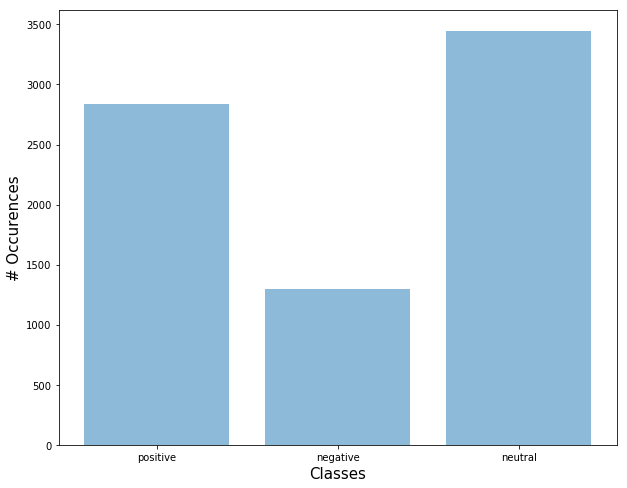

In [116]:
# The bar chart for the test data set

y = [len(t_df[t_df[2] == i]) for i in ['positive', 'negative', 'neutral']]
x = ['positive', 'negative', 'neutral']
x_pos = range(len(x))

plt.figure(figsize=(10,8))
plt.bar(x_pos, y, alpha=0.5)
plt.xticks(x_pos, x)
plt.ylabel('# Occurences').set_size(15)
plt.xlabel('Classes').set_size(15)

#### Pre-process tweets from the test dataset

In [117]:
# def check(mat):
#     assert type(mat) == np.ndarray
#     if np.any(np.isnan(mat)):
#         print ("NAN")
#     if not np.all(np.isfinite(mat)):
#         print ("infinite")
#     else:
#         print ("FREE")


In [118]:
raw_tweets_test = t_df[3]

t_unigram140Score, t_unigram140Reps = [], []
for tweet in raw_tweets_test:
    score, reps = unigram140Polarity(tweet.lower(), unigram140_d)
    t_unigram140Score.append(score)
    t_unigram140Reps.append(reps)

t_bigram140Score, t_bigram140Reps = [], []
for tweet in raw_tweets_test:
    score, reps = bigram140Polarity(tweet.lower(), bigram140_d)
    t_bigram140Score.append(score)
    t_bigram140Reps.append(reps)

t_SemEvalScore, t_SemEvalReps = [], []
for tweet in raw_tweets_test:
    score, reps = SemEvalLexiconPolarity(tweet.lower(), EnglishLexicon)
    t_SemEvalScore.append(score)
    t_SemEvalReps.append(reps)

In [119]:
raw_tweets_test = [replaceSlangs(tweet, slangs) for tweet in raw_tweets_test]
raw_tweets_test = [replace_apostrophe(tweet, apos) for tweet in raw_tweets_test]
raw_tweets_test = [subsEmoticon(tweet, dict) for tweet in raw_tweets_test]
raw_tweets_test = [handle_negation(tweet) for tweet in raw_tweets_test] #negation
lemmatized_tweets_test = [lemma(tweet) for tweet in raw_tweets_test]
preprocessed_tweets_test = [preprocess(tweet) for tweet in lemmatized_tweets_test]
final_tweets_test = [rem_stop(tweet) for tweet in preprocessed_tweets_test]
t_df[3] = final_tweets_test

del raw_tweets_test, lemmatized_tweets_test, preprocessed_tweets_test

In [120]:
t_raw_tweets_MPQA = [subsMPQA(tweet,dictionary) for tweet in final_tweets_test]
t_lemmatized_tweets_MPQA = [lemma(tweet) for tweet in t_raw_tweets_MPQA]
t_raw_tweets_bing = [subsBINGP(tweet, expanded_pos) for tweet in t_lemmatized_tweets_MPQA]
t_raw_tweets_bing = [subsBINGN(tweet, expanded_neg) for tweet in t_lemmatized_tweets_MPQA]

t_BingMpqaScore = []
t_AfinnScore, t_AfinnReps = [], []
t_WordnetScore, t_WordnetReps = [], []
t_length = len(t_raw_tweets_bing)

for tw in t_raw_tweets_bing:
    Bing_MPQA = 0
    for i in tw:
        if (i == 'positive'):
            Bing_MPQA +=  1
        if (i == 'negative'):
            Bing_MPQA -= 1
    t_BingMpqaScore.append(Bing_MPQA)
    tmp = afinnPolarity(tw, afinn)
    t_AfinnScore.append(tmp[0])
    t_AfinnReps.append(tmp[1])
    tmp = WordnetPolarity(tw, sentiWordnet)
    t_WordnetScore.append(tmp[0])
    t_WordnetReps.append(tmp[1])
print("Done scoring test set ..")
    
#reshape
t_BingMpqaScore = np.array(t_BingMpqaScore).reshape(t_length, 1)
t_AfinnScore = np.array(t_AfinnScore).reshape(t_length, 1)
t_AfinnReps = np.array(t_AfinnReps).reshape(t_length, 1)
t_WordnetScore = np.array(t_WordnetScore).reshape(t_length, 1)
t_WordnetReps = np.array(t_WordnetReps).reshape(t_length, 1)
t_SemEvalScore = np.array(t_SemEvalScore).reshape(t_length, 1)
t_SemEvalReps = np.array(t_SemEvalReps).reshape(t_length, 1)
t_unigram140Score = np.array(t_unigram140Score).reshape(t_length, 1)
t_unigram140Reps = np.array(t_unigram140Reps).reshape(t_length, 1)
t_bigram140Score = np.array(t_bigram140Score).reshape(t_length, 1)
t_bigram140Reps = np.array(t_bigram140Reps).reshape(t_length, 1)
print("Done reshaping test set ..")

Done scoring test set ..
Done reshaping test set ..


In [121]:
#Normalization
t_BingMpqaScore = t_BingMpqaScore/np.linalg.norm(t_BingMpqaScore)
t_AfinnScore = t_AfinnScore/np.linalg.norm(t_AfinnScore)
t_AfinnReps = t_AfinnReps/np.linalg.norm(t_AfinnReps)
t_WordnetScore = t_WordnetScore/np.linalg.norm(t_WordnetScore)
t_WordnetReps = t_WordnetReps/np.linalg.norm(t_WordnetReps)
t_SemEvalScore = t_SemEvalScore/np.linalg.norm(t_SemEvalScore)
t_SemEvalReps = t_SemEvalReps/np.linalg.norm(t_SemEvalReps)
t_unigram140Score = t_unigram140Score/np.linalg.norm(t_unigram140Score)
t_unigram140Reps = t_unigram140Reps/np.linalg.norm(t_unigram140Reps)
t_bigram140Score = t_bigram140Score/np.linalg.norm(t_bigram140Score)
t_bigram140Reps = t_bigram140Reps/np.linalg.norm(t_bigram140Reps)
print("Done normalizing test set ..")

t_all_scores = np.hstack( (t_BingMpqaScore, t_AfinnScore, t_WordnetScore, t_SemEvalScore, t_unigram140Score, t_bigram140Score) )
t_sum_score = np.sum(t_all_scores, axis=1).reshape(t_length, 1)
print (t_all_scores.shape)

# Delete
del t_raw_tweets_MPQA, t_lemmatized_tweets_MPQA, t_raw_tweets_bing

Done normalizing test set ..
(7584, 6)


In [122]:
t_df.head()

,0,1,2,3
2,282031301962395648,T14111200,neutral,dec st know end_not world_not baby_not boom_no...
3,11975,SM112166,negative,yar quite clever aft many guess lor got ask br...
4,136592,LJ112295,negative,yeah thin lizzy hate informercial
5,253421252956545024,T13114433,neutral,mt #syria deir ezzor ali bashar altheeb wa mar...
6,220880422320603137,T14114138,negative,hate life see_not roskilde_not festival_not sa...


#### Create the features vector

In [123]:
test_features = count_vectorizer.transform(final_tweets_test)
test_count_features = svd.transform(test_features)
test_count_features = scipy.sparse.csr_matrix(test_count_features)
print (test_count_features.shape)


test_tfidf_features = tfidf_vectorizer.transform(final_tweets_test)
test_tfidf_features = scipy.sparse.csr_matrix(test_tfidf_features)
print (test_tfidf_features.shape)

(7584, 5)
(7584, 139450)


In [124]:
t_final_total = scipy.sparse.csr_matrix(np.hstack( (t_all_scores, t_sum_score, t_AfinnReps, t_WordnetReps, t_SemEvalReps, t_unigram140Reps, t_bigram140Reps) ))
print (t_final_total.shape)
test_features = scipy.sparse.hstack([test_count_features, test_tfidf_features, t_final_total])
print (test_features.shape)

del t_all_scores, t_sum_score, t_BingMpqaScore, t_AfinnScore, t_WordnetScore, t_SemEvalScore, t_unigram140Score, t_bigram140Score
del t_AfinnReps, t_WordnetReps, t_SemEvalReps, t_unigram140Reps, t_bigram140Reps
del test_count_features, test_tfidf_features, t_final_total

(7584, 12)
(7584, 139467)


#### Get labels from a set of test data

In [125]:
actual_labels = t_df[2]
actual_labels = actual_labels.map(mapper)
actual_labels.shape

(7584,)

#### Predict labels using the template

In [126]:
predicted_labels = classifier.predict(test_features)

### Evaluate the Model
***

#### Evaluate the accuracy

In [128]:
print('Accuracy: {:0.2f}%'.format(metrics.accuracy_score(actual_labels, predicted_labels) * 100))

Accuracy: 68.01%


#### Accuracy of cross-validation 10 times on test data

In [129]:
# from sklearn import model_selection

# scores = model_selection.cross_val_score(classifier, test_features, actual_labels, cv=10, scoring='accuracy')
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
# del test_features

In [130]:
# draw the classification report
print('{}'.format(metrics.classification_report(actual_labels, predicted_labels)))

             precision    recall  f1-score   support

         -1       0.65      0.50      0.56      1296
          0       0.65      0.80      0.72      3448
          1       0.74      0.61      0.67      2840

avg / total       0.69      0.68      0.68      7584



See [Confusion Matrix](https://fr.wikipedia.org/wiki/Matrice_de_confusion) for more details


In [131]:
# Confusion Matrix
print('{}\n'.format(metrics.confusion_matrix(actual_labels, predicted_labels, labels=[1,-1,0])))
print("\x1b[31m\" macro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='macro')))
print("\x1b[31m\" micro f1 score \"\x1b[0m")
print('{}\n'.format(metrics.f1_score(actual_labels, predicted_labels, average='micro')))

[[1743  141  956]
 [ 144  644  508]
 [ 464  213 2771]]

" macro f1 score "
0.6514481371035035

" micro f1 score "
0.6801160337552743



### Comparison with the 5 best teams of subtask B

We compare our average f-score with the other teams in the workshop. The results are taken from the attached document:
[Final report SemEval 2014 Subtask 9](http://www.aclweb.org/anthology/S14-2009)

|Team|Accuracy (Macro Averaged)| Accuracy (Micro Averaged)|
|----|-------------------------|--------------------------|
|TeamX|65.63%|69.99%|
|coooolll|63.23%|70.51%|
|RTRGO|63.08%|70.15%|
|NRC-Canada|67.62%|71.37%|
|TUGAS|63.89%|68.84%|
|**_ME_**|_57.48%_|_64.86%_|
| | |***classement : 23 / 50***|
 